In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import loadmat
from utils.plotting_utils import topography_map
from scipy.signal import butter, filtfilt, resample
from snn.resonator import create_excitatory_inhibitory_resonator

from utils import copy_filter_hp_to_other_clock_frequency

EEG_FOLDER = f'../datasets/EEG_data_for_Mental_Attention_State_Detection'

trial = 4
# channel = 'O2'
channel = 'F4'

fs = 128

bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 14),
    'Beta': (14, 32),
    'Gamma': (32, 60),
}

data_root = f'{EEG_FOLDER}/EEG_Data'

# Channels
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# Util Methods

In [2]:
from scipy.stats import zscore

# number of samples in the original and resampled signals
def resample_signal(f_new, f_source, data):
    n_samples_orig = data.shape[0]
    n_samples_new = int(n_samples_orig * f_new / f_source)

    # resample the signal
    return resample(data, n_samples_new)

def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt


#  Function to read in the EEG data and extract the valid lead data, low and high pass filter and z-transform the data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = fs
    #filename = 'eeg_record30.mat'
    mat = loadmat(f'{data_root}/{filename}')
    data = pd.DataFrame.from_dict(mat["o"]["data"][0,0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1,2, 3, 4,5,6, 7, 8, 9,10,11,12,13,14,17], axis=1)
    labels = ['AF3','F7', 'F3','FC5','T7','P7','O1', 'O2','P8','T8', 'FC6','F4','F8','AF4']  # FP2 should really be AF4
    dat.columns = labels

    # Filter the data, high pass .5 Hz, low pass 62 Hz.
    lo, hi = .5, 62
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i, c in enumerate(labels)})

    # Z-transform each column
    # dat = dat.apply(zscore)

    return dat

def get_trial_data(trial):
    dat = get_EEG_data(data_root, f'eeg_record{trial}.mat')
    return dat


def plot_spectrogram2(data, channel_name, fs, fmin, fmax, show=True):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=2*fs, Fs=fs,
                                         noverlap=fs, cmap='jet')
    # plt.vlines([600, 1200], ymin=fmin, ymax=fmax, colors='black')
    if show:
        plt.ylim(fmin, fmax)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f'ch={channel_name} fs={fs} band=({fmin} - {fmax})Hz')
        plt.imshow(Sxx, aspect='auto',
                   cmap='jet', origin='lower',
                   extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
                   vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
        plt.colorbar()
    else:
        plt.close()
    return Sxx

def plot_spectrogram(data, channel_name, fs, fmin, fmax, show=True):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    f, t, Sxx = signal.spectrogram(data, fs, noverlap=0, nperseg=fs)
    Sxx = Sxx[:, :-1]
    if show:
        plt.ylim(fmin, fmax)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f'ch={channel_name} fs={fs} band=({fmin} - {fmax})Hz')
        plt.imshow(Sxx, aspect='auto',
                   cmap='jet', origin='lower',
                   extent=[t[0], t[-1], f[0], f[-1]],
                   # vmin=0, vmax=np.max(Sxx),
                   )
        plt.colorbar()
    else:
        plt.close()
    return Sxx

def fft_spectogram2bins(Sxx, window):
    bins_count = len(Sxx[0])//window + 1
    bin_sxx = np.zeros((len(bands), bins_count))

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(bands.values()):
        for i in range(bins_count):
            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:(i+1)*window]) / (f_max - f_min)
        bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:]) / (f_max - f_min)

    return bin_sxx

def plot_bins(Sxx, duration, labels, annotate=True, rotate_annotate=False, show=True, colorbar=True, gridlines=False):
    fig, ax = plt.subplots(figsize=(14, 5))
    im = ax.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[0, duration, 0, len(Sxx)]
               )

    ax.set_yticks(np.arange(.5, len(Sxx)+.5), labels=labels)
    if annotate:
        bin_size = duration / len(Sxx[0])
        rotation_degree = 90 * rotate_annotate
        for i in range(len(Sxx)):
            for j in range(len(Sxx[i])):
                text = ax.text(j * bin_size + bin_size*.5, i + .5,  f'{Sxx[i, j]:.4f}',
                               rotation=rotation_degree,
                               ha="center", va="center", color="white")

    if gridlines:
        ax.set_yticks(np.arange(0, len(labels)), minor=True)
        ax.grid(which='minor', color='grey', linestyle='-', linewidth=1)
    fig.tight_layout()
    if colorbar:
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_ticks([])
    if show:
        plt.show()
    return ax


def array_to_bins(array, N):
    bins = np.array_split(array, N)
    bin_sums = np.array([np.sum(bin) for bin in bins], dtype=np.int64)
    return bin_sums


def spikes_to_bands(spikes_spectrogram, freqs):
    freqs = np.array(freqs) # im here
    bands_spectrogram = np.zeros((len(bands), spikes_spectrogram.shape[1]))
    bands_spectrogram[0] = np.sum(spikes_spectrogram[(freqs >= 1) & (freqs < 4)], axis=0) / sum(freqs[(freqs >= 1) & (freqs < 4)])
    bands_spectrogram[1] = np.sum(spikes_spectrogram[(freqs >= 4) & (freqs < 8)], axis=0) / sum(freqs[(freqs >= 4) & (freqs < 8)])
    bands_spectrogram[2] = np.sum(spikes_spectrogram[(freqs >= 8) & (freqs < 14)], axis=0) / sum(freqs[(freqs >= 8) & (freqs < 14)])
    bands_spectrogram[3] = np.sum(spikes_spectrogram[(freqs >= 14) & (freqs < 32)], axis=0) / sum(freqs[(freqs >= 14) & (freqs < 32)])
    bands_spectrogram[4] = np.sum(spikes_spectrogram[(freqs >= 32) & (freqs < 62)], axis=0) / sum(freqs[(freqs >= 32) & (freqs < 62)])
    return bands_spectrogram


def spikes_event_spectrogram(clk_freq, events, window_ms, duration_s=None):
    window = clk_freq / 1000 * window_ms
    if duration_s is None:
        duration_s = events[-1] + 1
    else:
        duration_s *= clk_freq
    N = duration_s / window
    if N != int(N):
        N = int(N) + 1
    else:
        N = int(N)
    bins = np.zeros(N, dtype=int)
    unique_indices, counts = np.unique(events // window, return_counts=True)
    bins[unique_indices.astype(int)] = counts
    return bins


def create_spikes_spectrogram(clk_freq, spikes, window_ms, duration_s):
    window = int(clk_freq / 1000 * window_ms)
    N = duration_s / window
    if N != int(N):
        N = int(N) + 1
    else:
        N = int(N)
    bins = np.sum(spikes[:window * N].reshape(-1, window), axis=1)
    return bins

## Choose a signal, visualize in time and frequency domain.

In [3]:
example_data = get_trial_data(trial)

### FFT Plot on all of the signal
Plot a fft spectrogram and in bins to be able to see more accuratly where is most of the activation.

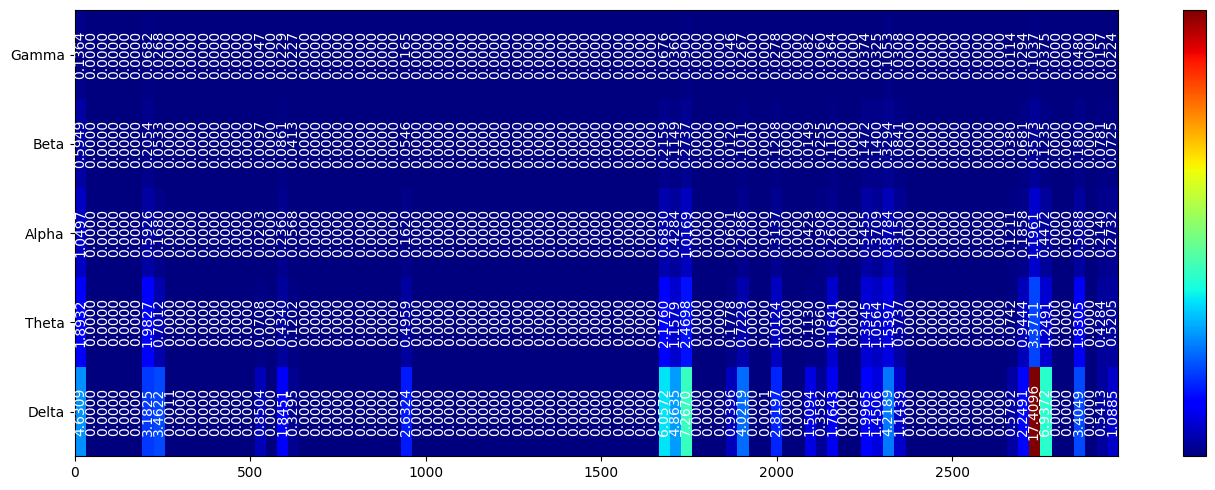

<Axes: >

In [4]:
fft_spectogram = plot_spectrogram(example_data[channel], channel_name=channel, fs=fs, fmin=2, fmax=40, show=False)
fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, 32)
plot_bins(fft_bin_spectogram, len(example_data[channel])/fs, bands.keys(), annotate=True, rotate_annotate=True)

### Choose a slice from the signal for faster study

In [5]:
time_start_s = 1670
time_end_s = 1715
sliced_data = example_data[channel][time_start_s*fs:time_end_s*fs]

# time_start_s = 4 * 60
# time_end_s = 5 * 60
# sliced_data = example_data[channel][time_start_s*fs:time_end_s*fs]

Text(0.5, 1.0, 'Signal on Time domain')

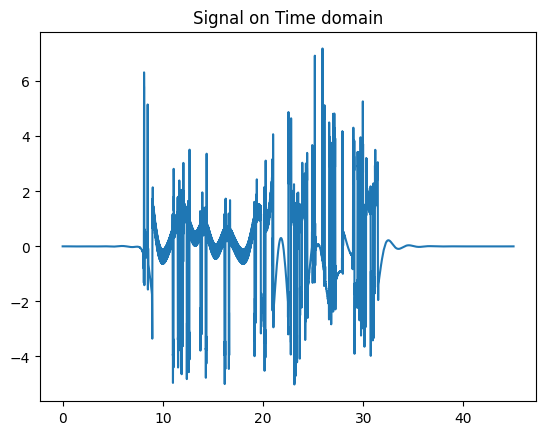

In [6]:
plt.plot(np.linspace(0, time_end_s-time_start_s, len(sliced_data)) , sliced_data)
# plt.title('Slice data on Time domain')
plt.title('Signal on Time domain')

In [7]:
# labels = list(map(lambda x: '\n'.join(x), zip(bands.keys(), ['1Hz - 4Hz', '4Hz - 8Hz', '8Hz - 14Hz', '14Hz - 32Hz', '32Hz - 60Hz'])))
labels = list(map(lambda x: '\n'.join(x), zip(bands.keys(), ['1Hz - 4Hz', '4Hz - 8Hz', '8Hz - 14Hz', '14Hz - 32Hz', '32Hz - 60Hz'])))
labels

['Delta\n1Hz - 4Hz',
 'Theta\n4Hz - 8Hz',
 'Alpha\n8Hz - 14Hz',
 'Beta\n14Hz - 32Hz',
 'Gamma\n32Hz - 60Hz']

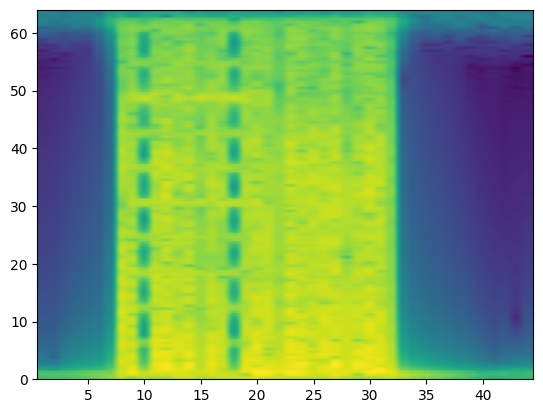

In [8]:
plt.specgram(sliced_data, Fs=fs)
None

(5, 45)

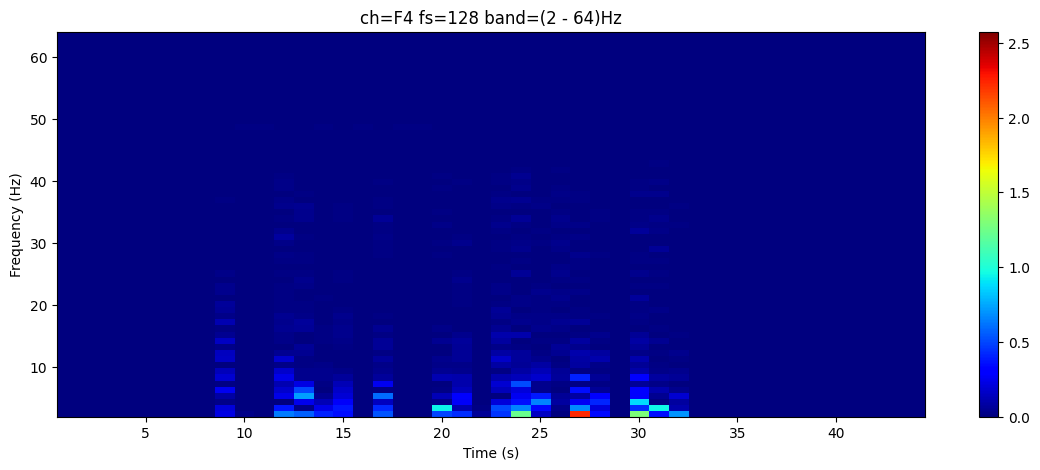

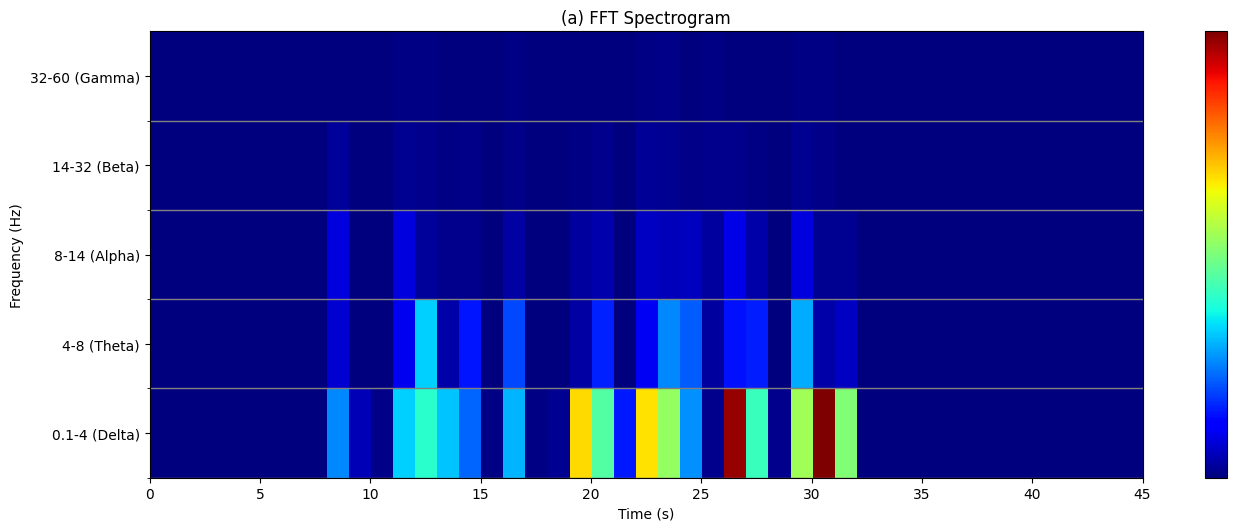

In [9]:
sliced_data = example_data[channel][time_start_s*fs:time_end_s*fs]

fft_spectogram = plot_spectrogram(sliced_data, channel_name=channel, fs=fs, fmin=2, fmax=64, show=True)
fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, 1)
labels = ['0.1-4', '4-8', '8-14', '14-32', '32-60']
labels = [f'{f} ({band})' for f, band in  zip(labels, bands.keys())]
ax = plot_bins(fft_bin_spectogram, len(sliced_data)/fs, labels, annotate=False, rotate_annotate=True,
               show=False, colorbar=True, gridlines=True)
plt.title('(a) FFT Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mean amplitude per band')
plt.ylabel('Frequency (Hz)')


fft_bin_spectogram.shape

### Spikes Visualization

Normalize the data first!

In [10]:
sliced_data /= np.max(np.abs(sliced_data))

In [11]:
resonators_freqs = np.concatenate([np.linspace(start, stop, 7)[1:-1] for start, stop in bands.values()])
clk_resonators = {
    15360: resonators_freqs[resonators_freqs < 10].tolist(),
    153600: resonators_freqs[resonators_freqs >= 10].tolist(),
}
clk_resonators = {
    15360: [1.1, 1.3, 1.6, 1.9, 2.2, 2.5, 2.88, 3.05, 3.39, 3.7, 4.12, 4.62, 5.09, 5.45, 5.87, 6.36, 6.8, 7.6, 8.6],
    153600: [10.5, 11.5, 12.8, 15.8, 16.6, 19.4, 22.0, 24.8, 28.4, 30.5, 34.7, 37.2, 40.2, 43.2, 47.7, 52.6, 57.2]
}
main_clk = max(clk_resonators.keys())

In [12]:
res = []
for f0 in clk_resonators[15360]:# + clk_resonators[153600]:
    configured_freq = f0 * 100
    root_folder = f'../filters4_xi0/clk_1536000/parameters/'
    available_resonators = np.array([int(f[2:-5]) for f in os.listdir(root_folder)])
    arg_chosen_resonator = np.argmin(np.abs(available_resonators - configured_freq))
    res.append(available_resonators[arg_chosen_resonator])

for f0 in clk_resonators[153600]:
    configured_freq = f0 * 10
    root_folder = f'../filters4_xi0/clk_1536000/parameters/'
    available_resonators = np.array([int(f[2:-5]) for f in os.listdir(root_folder)])
    arg_chosen_resonator = np.argmin(np.abs(available_resonators - configured_freq))
    res.append(available_resonators[arg_chosen_resonator])
print(res)
len(res)

[110, 130, 160, 190, 221, 250, 288, 305, 339, 372, 412, 462, 509, 545, 587, 636, 694, 763, 898, 105, 115, 128, 159, 166, 195, 221, 250, 282, 305, 347, 372, 402, 436, 477, 526, 587]


36

### Generate spikes for the resonators.

In [13]:
from snn.resonator import trained_resonator
from tqdm import tqdm

output = {}

with tqdm(total=36) as pbar:
    for clk_freq, list_of_f0 in clk_resonators.items():
        output[clk_freq] = []
        sliced_data_resampled = resample_signal(clk_freq, fs, sliced_data)
        for f0 in list_of_f0:
            resonator = trained_resonator(
                freq0=float(f0),
                filters_folder='filters4_xi0'
            )
            resonator.log_out_spikes(-1)
            output_neuron = resonator.layers_neurons[-1].neurons[-1]
            resonator.input_full_data(sliced_data_resampled)
            # extract the spikes without the appended zeros
            output[clk_freq].append(output_neuron.out_spikes())
            pbar.update(1)

with open('sliced_data_output.pickle', 'wb') as f:
    pickle.dump(output, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 36/36 [09:26<00:00, 15.73s/it]


In [338]:
import pickle

with open('sliced_data_output.pickle', 'rb') as f:
    output = pickle.load(f)

28.4

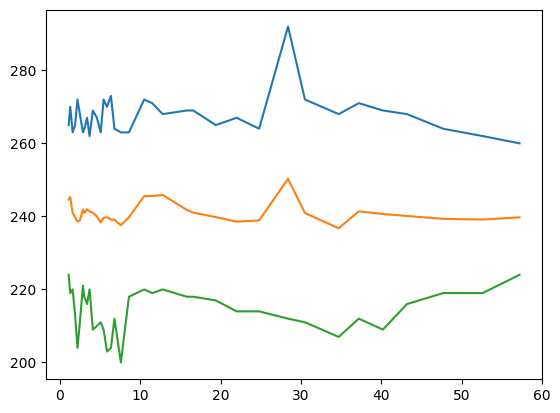

In [14]:
duration = time_end_s - time_start_s

freqs = []
max_spikes = []
mean_spikes = []
min_spikes = []
amplitude_spikes = []

for clk_freq, list_of_f0 in clk_resonators.items():
    for i, f0 in enumerate(list_of_f0):
        events = output[clk_freq][i]
        y_spikes = np.zeros(clk_freq * duration)
        y_spikes[events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
        freqs.append(f0)
        max_spikes.append(y_spikes.max())
        mean_spikes.append(y_spikes.mean())
        min_spikes.append(y_spikes.min())
        amplitude_spikes.append(y_spikes.max() - y_spikes.min())

plt.plot(freqs, max_spikes)
plt.plot(freqs, mean_spikes)
plt.plot(freqs, min_spikes)
# plt.plot(freqs, amplitude_spikes)
freqs[np.argmax(max_spikes)]

In [342]:
np.argmax(max_spikes)

27

### 1 Resonator

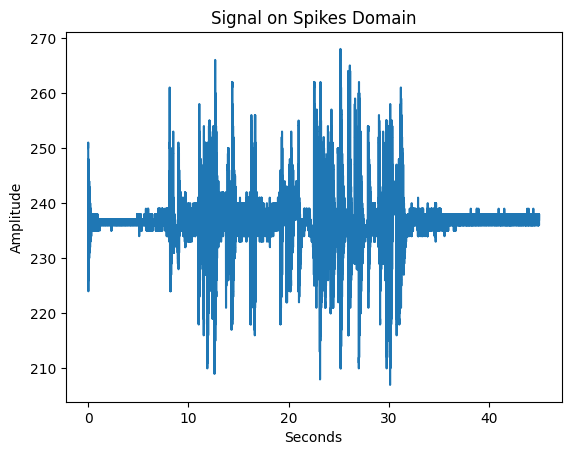

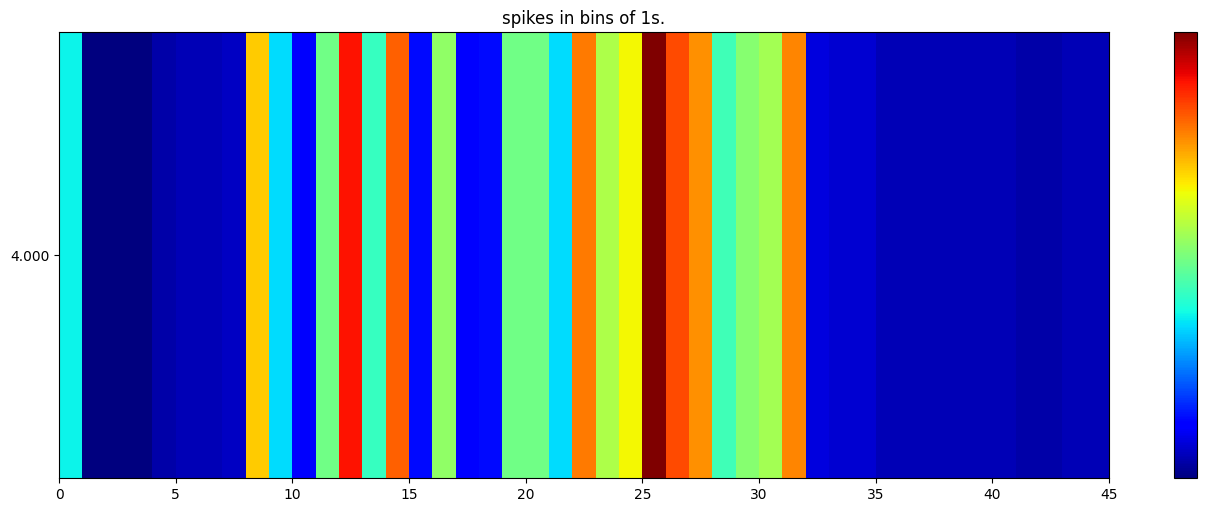

In [15]:
events = output[clk_freq][10]
y_spikes = np.zeros(clk_freq * duration)
y_spikes[events] = 1
y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
plt.plot(np.linspace(0, duration, len(y_spikes)), y_spikes)
plt.xlabel('Seconds')
plt.ylabel('Amplitude')
plt.title('Signal on Spikes Domain')
plt.show()

spikes_spectrogram = np.zeros((1, (duration * 1000)// 10))
max_spikes_spectrogram = np.zeros((1, (duration * 1000) // 1000))
spikes_spectrogram[0] = spikes_event_spectrogram(clk_freq, events, 10, duration)
max_spikes_spectrogram[0] = spikes_spectrogram[0].reshape(-1, len(spikes_spectrogram[0])//len(max_spikes_spectrogram[0])).max(axis=1)

plot_bins(max_spikes_spectrogram, max_spikes_spectrogram.shape[1], labels=['4.000'], annotate=False, show=False, rotate_annotate=True)
plt.title('spikes in bins of 1s.')
plt.show()

### All the resonators

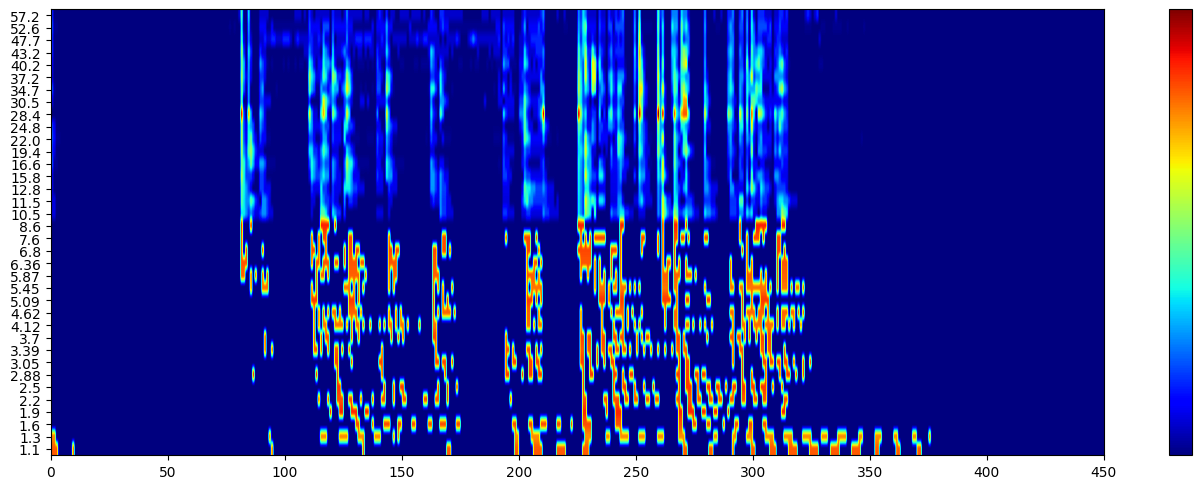

<Axes: >

In [16]:
def events_to_max_spectrogram(resonators_by_clk, duration):
    spikes_array = sum(resonators_by_clk.values(), start=[])

    max_spikes_spectrogram = np.zeros((len(spikes_array), (duration * 1000) // 100))
    # axis 0 - resonators
    # axis 1 - number of bins ( I set to 1ms)
    i = 0
    for clk_freq, spikes_arrays in resonators_by_clk.items():
        for events in spikes_arrays:
            spikes_spectrogram = spikes_event_spectrogram(clk_freq, events, 1)
            max_spikes_spectrogram[i] = spikes_spectrogram.reshape(-1, len(spikes_spectrogram)//len(max_spikes_spectrogram[i])).max(axis=1)
            max_spikes_spectrogram[i] *= main_clk/clk_freq
            max_spikes_spectrogram[i] -= np.mean(max_spikes_spectrogram[i])
            max_spikes_spectrogram[i][max_spikes_spectrogram[i] < 0] = 0
            i += 1
    return max_spikes_spectrogram

max_spikes_spectrogram = events_to_max_spectrogram(output, duration)
plot_bins(max_spikes_spectrogram, max_spikes_spectrogram.shape[1], labels=sum(clk_resonators.values(), []), annotate=False)

Text(49.472222222222214, 0.5, 'Frequency (Hz)')

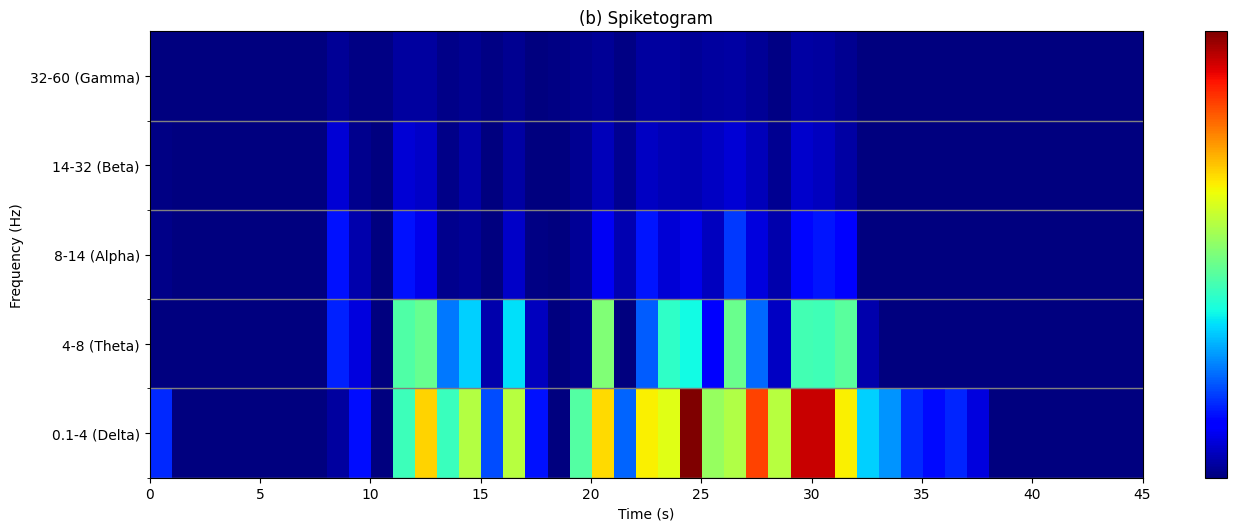

In [17]:
full_resonators_freqs = sum(clk_resonators.values(), [])
spikes_bands_spectrogram = spikes_to_bands(max_spikes_spectrogram, full_resonators_freqs)

spikes_bands_spectrogram = spikes_bands_spectrogram.reshape(spikes_bands_spectrogram.shape[0], spikes_bands_spectrogram.shape[1]//10, 10).sum(axis=2)
labels = ['0.1-4', '4-8', '8-14', '14-32', '32-60']
labels = [f'{f} ({band})' for f, band in  zip(labels, bands.keys())]

plot_bins(spikes_bands_spectrogram, len(sliced_data)/fs, labels=labels, annotate=False,
          rotate_annotate=True, show=False, colorbar=True, gridlines=True)

# plt.grid(color='w', linewidth=1)
plt.title('(b) Spiketogram')
plt.xlabel('Time (s)')
# plt.ylabel('Spikes rate per band')
plt.ylabel('Frequency (Hz)')

In [18]:
print(f'full correlation {np.corrcoef(fft_bin_spectogram.flatten(), spikes_bands_spectrogram.flatten())[0, 1]}')

for i, band in enumerate(bands.keys()):
    print(f'{band} correlation {np.corrcoef(fft_bin_spectogram[i], spikes_bands_spectrogram[i])[0, 1]}')

full correlation 0.8100432211315721
Delta correlation 0.759022262934685
Theta correlation 0.8296187832403376
Alpha correlation 0.8815044675537542
Beta correlation 0.9368458751210731
Gamma correlation 0.9137882941985908


### Load Preprocessed Spikes Data.

In [20]:
from pathlib import Path


class ResonatorSpikes:

    def __init__(self, clk_freq, resonator_freq, spikes_path):
        self.clk_freq = clk_freq
        self.resonator_freq = resonator_freq
        self.events = None
        self._load_spikes(spikes_path)

    def _load_spikes(self, spikes_path):
        spikes_array = np.load(spikes_path)['spikes']
        # if the file is already events based spikes
        if np.max(spikes_array[:3]) > 1:
            self.events = spikes_array
        else:
            self.events = np.where(spikes_array == 1)[0]

    def spectrogram(self, window_ms):
        window = int(self.clk_freq/1000 * window_ms)
        N = self.events[-1] // window + 1
        bins = np.zeros(N, dtype=int)
        unique_indices, counts = np.unique(np.array(self.events) // window, return_counts=True)
        bins[unique_indices] = counts
        return bins



class ChannelSpikes:

    def __init__(self, base_folder, channel_name):
        self.channel_name = channel_name
        self.resonators_output = {}
        self._load_resonators_output(base_folder)

    def _load_resonators_output(self, base_folder):
        channel_folder = base_folder / self.channel_name
        for clk_freq in os.listdir(channel_folder):
            clk_folder = channel_folder / clk_freq
            for spikes in os.listdir(clk_folder):
                resonator_freq = spikes[:-4]
                self.resonators_output[resonator_freq] = ResonatorSpikes(int(clk_freq), float(resonator_freq), f'{clk_folder}/{spikes}')

class SignalSpikes:

    def __init__(self, signal_folder, label):
        self.label = label
        self.channels = {
            channel: ChannelSpikes(signal_folder, channel)
            for channel in os.listdir(signal_folder)
        }


class Trial:

    def __init__(self, base_folder, trial):
        self.trial = trial
        self.base_folder = Path(f'{base_folder}/{trial}')

    def load(self, minutes):
        # make sure it's in string format.
        if type(minutes) not in [tuple, list]:
            minutes = [minutes]
        minutes = [str(m) for m in minutes]
        res = []
        for label in os.listdir(self.base_folder):
            labeled_minutes = os.listdir(self.base_folder / label)
            res += [SignalSpikes(self.base_folder / label / m, label=label) for m in minutes if m in labeled_minutes]
        return res

In [21]:
trial = Trial(f'../datasets/EEG_data_for_Mental_Attention_State_Detection/EEG_spikes/', 4)
signal_spikes = trial.load([4])[0]

In [22]:
signal_spikes.channels

{'FC6': <__main__.ChannelSpikes at 0x12bedc1c0>,
 'F4': <__main__.ChannelSpikes at 0x12bd3d7e0>,
 'F3': <__main__.ChannelSpikes at 0x12bec17e0>,
 'O2': <__main__.ChannelSpikes at 0x12bf15cc0>,
 'AF4': <__main__.ChannelSpikes at 0x12bf170d0>,
 'AF3': <__main__.ChannelSpikes at 0x12bf158a0>,
 'P7': <__main__.ChannelSpikes at 0x12bea21a0>,
 'P8': <__main__.ChannelSpikes at 0x12bea35b0>,
 'FC5': <__main__.ChannelSpikes at 0x12be96ce0>,
 'O1': <__main__.ChannelSpikes at 0x12bf16f80>,
 'F7': <__main__.ChannelSpikes at 0x12be6b6d0>,
 'F8': <__main__.ChannelSpikes at 0x12be6bac0>,
 'T8': <__main__.ChannelSpikes at 0x12be6b280>,
 'T7': <__main__.ChannelSpikes at 0x12be75f90>}

In [23]:
sig = signal_spikes.channels['O1'].resonators_output['12.8']

window = int(sig.clk_freq/1000 * 15)
N = sig.events[-1] // window + 1
bins = np.zeros(N, dtype=int)
unique_indices, counts = np.unique(np.array(sig.events) // window, return_counts=True)
bins[unique_indices] = counts

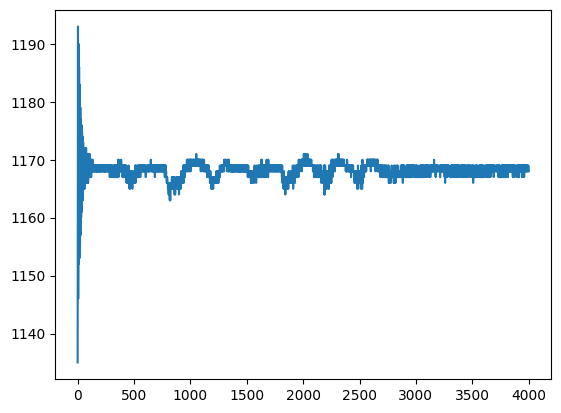

In [24]:
plt.plot(bins)

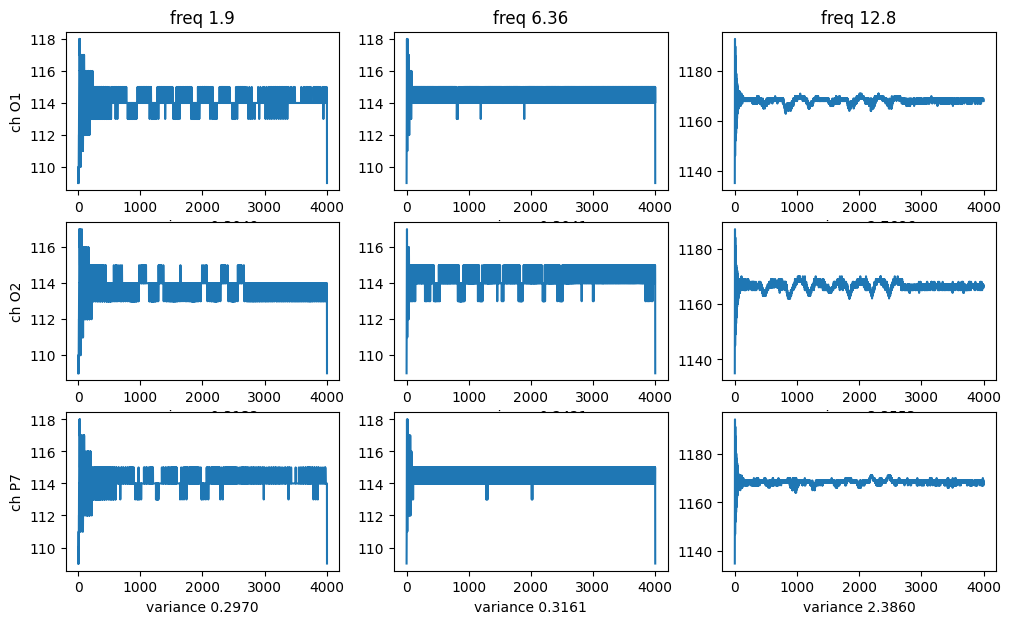

In [25]:
freqs = ['1.9', '6.36', '12.8']
ch_names = ['O1', 'O2', 'P7']
fig, axs = plt.subplots(len(ch_names), 3, figsize=(12, 7))
for i, ch_name in enumerate(ch_names):
    for j, freq in enumerate(freqs):
        ax = axs[i, j]
        sig_spectrogram = signal_spikes.channels[ch_name].resonators_output[freq].spectrogram(15)
        ax.plot(sig_spectrogram)
        if j == 0:
            ax.set_ylabel(f'ch {ch_name}')
        if i == 0:
            ax.set_title(f'freq {freq}')
        ax.set_xlabel(f'variance {np.var(sig_spectrogram):.4f}')



## Topograph Map

In [26]:
fs = 128

class Subject:

    def __init__(self, number, slice_from, slice_to, sample_length=10):
        self.number = number
        # records = np.arange(1, 7) + (number * 7)
        trials = np.arange(3, 7) + (number * 7)
        trials = [4]
        self.focus_label = Label('focus', trials, slice_from, slice_to, sample_length)
        self.unfocus_label = Label('unfocus', trials, slice_from + 600, slice_to + 600, sample_length)
        self.drowsed_label = Label('drowsed', trials, slice_from + 1200, slice_to + 1200, sample_length)


class Label:

    def __init__(self, label, trials, slice_from, slice_to, sample_length):
        self.label = label
        self.slice_to = slice_to
        self.slice_from = slice_from
        self.sample_length = sample_length

        samples = np.arange(0, slice_to - slice_from, sample_length)
        topographic = {ch: np.zeros((len(samples) * len(trials), fs//2 + 1, sample_length))
                       for ch in channels}
        time_signals = {ch: np.zeros((len(samples) * len(trials), fs * sample_length))
                       for ch in channels}
        for i, trial in enumerate(trials):
            trial_data = get_trial_data(trial)
            for ch in trial_data.columns:
                fft_spectogram = plot_spectrogram(trial_data[ch][slice_from * fs:slice_to * fs], channel_name=ch, fs=fs, fmin=0, fmax=63, show=False)
                for j, sample in enumerate(samples):
                    # fft_spectogram.shape[1] is 129, probably not divided by sample length.
                    actual_sample_length = fft_spectogram[:, sample:sample+sample_length].shape[1]
                    topographic[ch][i * len(samples) + j, :, :actual_sample_length] = fft_spectogram[:, sample:sample+sample_length]

                    # time domain signal
                    time_signals[ch][i * len(samples) + j, :] = trial_data[ch][(slice_from + sample) * fs:(slice_from + sample+sample_length) * fs]

        self.topographic = topographic
        self.time_signals = time_signals

slice_from = 240
slice_to = 300
subject0 = Subject(0, slice_from, slice_to)

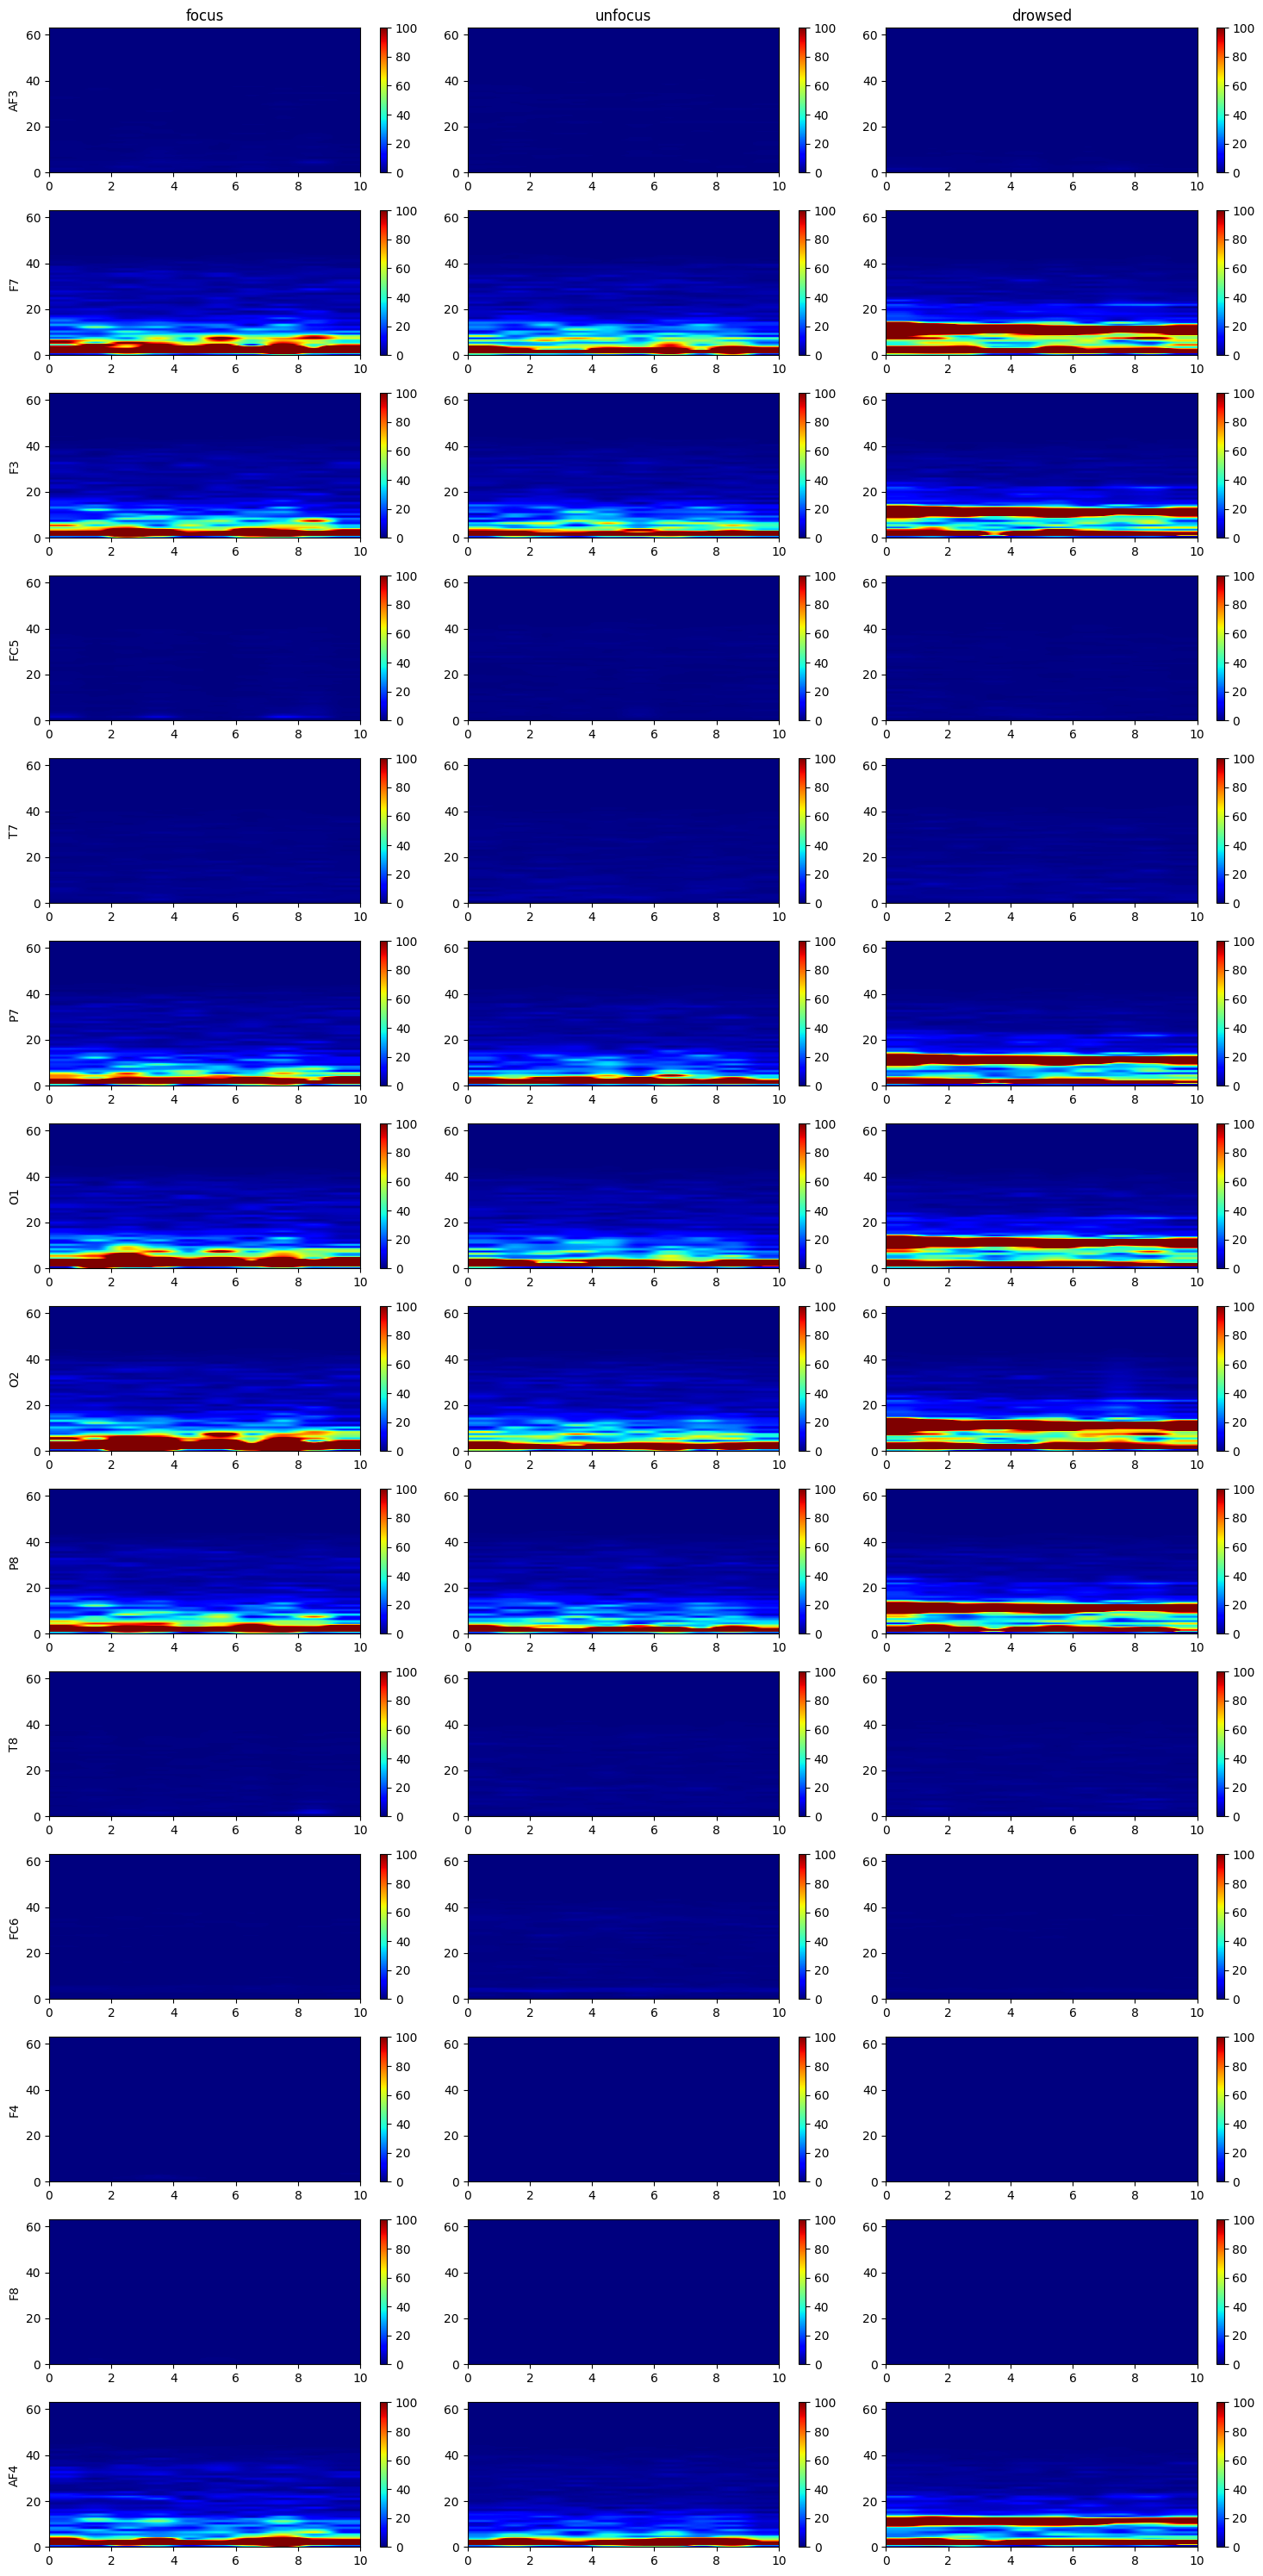

In [27]:
# Create the figure and axes
fig, axs = plt.subplots(14, 3, figsize=(15, 30))

# Iterate through the subplots
labels = [subject0.focus_label, subject0.unfocus_label, subject0.drowsed_label]
fmin, fmax = 0, 63
for j, label_inst in enumerate(labels):
    axs[0, j].title.set_text(label_inst.label)
    for i, (ch, top) in enumerate(label_inst.topographic.items()):
        ax = axs[i, j]
        im = ax.imshow(
            top.sum(axis=0), aspect='auto',
            cmap='jet', origin='lower',
            extent=[0, label_inst.sample_length, fmin, fmax],
            vmin=0, vmax=100
        )

        cbar = fig.colorbar(im, ax=ax)
        axs[i, 0].set_ylabel(ch)


# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Check Active Channels

In [239]:
# Iterate through the subplots
def create_df_features(subject):

    labels = [subject.focus_label, subject.unfocus_label, subject.drowsed_label]

    df_mean_data = {
        f'{inst_label.label}_{ch}': []
        for inst_label in labels
        for ch in inst_label.time_signals.keys()
    }

    df_max_data = {
        f'{inst_label.label}_{ch}': []
        for inst_label in labels
        for ch in inst_label.time_signals.keys()
    }

    df_std_data = {
        f'{inst_label.label}_{ch}': []
        for inst_label in labels
        for ch in inst_label.time_signals.keys()
    }

    for j, label_inst in enumerate(labels):
        axs[0, j].title.set_text(label_inst.label)
        for i, (ch, sig) in enumerate(label_inst.time_signals.items()):
            for sample in sig:
                df_mean_data[f'{label_inst.label}_{ch}'].append(np.mean(sample))
                df_max_data[f'{label_inst.label}_{ch}'].append(np.max(sample))
                df_std_data[f'{label_inst.label}_{ch}'].append(np.std(sample))

    df_mean = pd.DataFrame(df_mean_data)
    df_max = pd.DataFrame(df_max_data)
    df_std = pd.DataFrame(df_std_data)

    return df_mean, df_max, df_std


def create_ch_feature(subject, label, feature):
    feature_id = {
        'mean': 0,
        'max': 1,
        'std': 2
    }[feature]
    df = create_df_features(subject)[feature_id]
    selected_columns = df.columns[df.columns.str.startswith(label)]
    df = df[selected_columns]
    ch_columns = np.array(list(df.columns.str.split('_').values))[:, 1]
    df.columns = ch_columns
    return df

def check_ch_activation(subject, label, feature, threshold):
    df = create_ch_feature(subject, label, feature)
    df = df > threshold

    row_counts = df.apply(lambda row: '-'.join(df.columns[row]), axis=1).value_counts().to_dict()
    return row_counts

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

for sample_length in [20, 10, 5, 3, 1]:
    subjects = [Subject(i, slice_from, slice_to, sample_length=sample_length) for i in range(5)]
    concatenated_dfs = []
    for subject in subjects:
        df1 = create_ch_feature(subject, 'focus', 'std')
        df1['label'] = 'focus'
        df2 = create_ch_feature(subject, 'unfocus', 'std')
        df2['label'] = 'unfocus'
        df3 = create_ch_feature(subject, 'drowsed', 'std')
        df3['label'] = 'drowsed'
        concatenated_dfs.append(pd.concat([df1, df2, df3], ignore_index=True))

    concatenated_df = pd.concat(concatenated_dfs, ignore_index=True)
    X = concatenated_df[channels]
    y = concatenated_df['label']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    dt_classifier = RandomForestClassifier()
    dt_classifier.fit(X_train, y_train)

    predictions = dt_classifier.predict(X_val)
    acc = np.sum(predictions == y_val)/len(y_val)
    print(f'For sample length of {sample_length}s the accuracy is {acc*100:.2f}')

KeyboardInterrupt: 

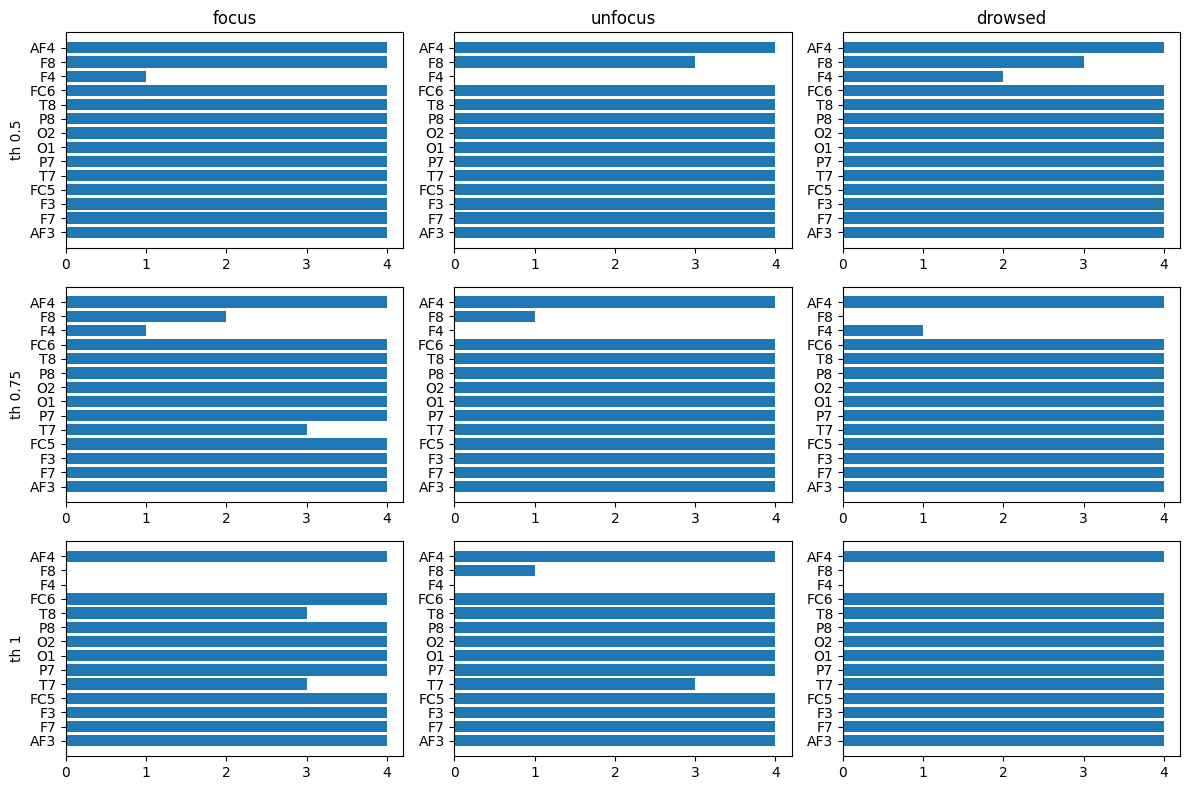

In [51]:
# Create the figure and axes
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

# Iterate through the subplots
labels = [subject0.focus_label, subject0.unfocus_label, subject0.drowsed_label]
thresholds = [.5, .75, 1]
for j, label_inst in enumerate(labels):
    axs[0, j].title.set_text(label_inst.label)
    for i, th in enumerate(thresholds):
        activities = check_ch_activation(subjects[0], label_inst.label, 'std', th)
        count_active_channels = dict(zip(channels, np.zeros(len(channels))))

        for active_channels, value in activities.items():
            if active_channels == '':
                continue
            active_channels = active_channels.split('-')
            for ch in active_channels:
                count_active_channels[ch] += value


        keys = list(count_active_channels.keys())
        values = list(count_active_channels.values())
        ax = axs[i, j]
        im = ax.barh(keys, values)

        axs[i, 0].set_ylabel(f'th {th}')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [240]:
activities = check_ch_activation(subjects[0], 'drowsed', 'std', .5)
count_active_channels = dict(zip(channels, np.zeros(len(channels))))
count_active_channels[''] = 0

for active_channels, value in activities.items():
    active_channels = active_channels.split('-')
    for ch in active_channels:
        count_active_channels[ch] += value


keys = list(count_active_channels.keys())
values = list(count_active_channels.values())
plt.barh(keys, values)

plt.xlabel('Appearance')
plt.ylabel('Channels')
plt.title('Channels Appearance')

# Display the plot
plt.show()

KeyError: 0

# Topography Map

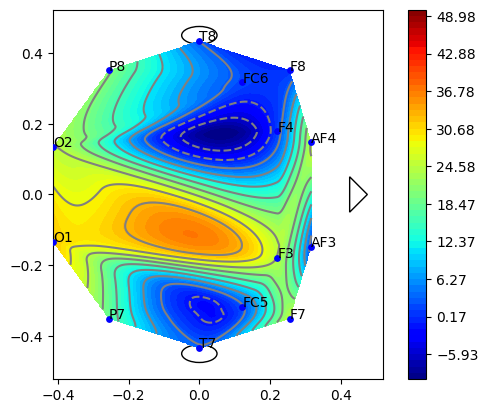

In [28]:
dat = get_trial_data(4)
fig, _ = topography_map(dat.iloc[time_start_s * 128: time_end_s * 128], vmin=-10, vmax=50)

In [29]:
dat.iloc[slice_from * 128: slice_to * 128].to_csv('trial2_s120_focus.csv')
# dat.iloc[(600 + slice_from) * 128: (600 + slice_to) * 128].to_csv('trial2_s720_unfocus.csv')
# dat.iloc[(1200 + slice_from) * 128: (1200 + slice_to) * 128].to_csv('trial2_s1320_drowsed.csv')

In [245]:
from tqdm.notebook import tqdm
import matplotlib.animation as animation
from PIL import Image
import imageio


def topographic_gif(trial, label):
    sprite_dir = '.sprite'
    dat = get_trial_data(trial)

    seconds = {
        'focus': range(3 * 60, 3 * 60),
        'unfocus': range(13 * 60, 13 * 60),
        'drowsed': range(23 * 60, 23 * 60),
    }[label]
    vmin=-100
    vmax=400
    for second in tqdm(seconds):
        fig, _ = topography_map(dat.iloc[second * 128: (second + 1) * 128], vmin=vmin, vmax=vmax)
        plt.savefig(f"{sprite_dir}/{second}.png", dpi=80)
        plt.close(fig)


    image_files = sorted([f for f in os.listdir(sprite_dir) if f.endswith('.png')],
                         key=lambda x: int(os.path.splitext(x)[0]))
    frames = []
    for image_file in image_files:
        image_path = os.path.join(sprite_dir, image_file)
        image = Image.open(image_path)
        frames.append(image)

    for i in range(20):
        frames.append(np.zeros_like(image))
    output_path = f'.gifs/{trial}_{label}.gif'
    imageio.mimwrite(output_path, frames, fps=10)
    # frames[0].save(output_path, format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=True)

    for image, image_file in zip(frames[:-20], image_files):
        image.close()
        image_path = os.path.join(sprite_dir, image_file)
        os.remove(image_path)

In [55]:
for trial in range(3, 7):
    topographic_gif(trial, 'focus')
    topographic_gif(trial, 'unfocus')
    topographic_gif(trial, 'drowsed')

0it [00:00, ?it/s]

FileNotFoundError: [WinError 3] The system cannot find the path specified: '.sprite'

In [30]:
def mean_signal(signal, start, end, step, fs):
    res = signal.iloc[start * fs:(start + step) * fs].reset_index(drop=True)
    for i in range(start + step, end, step):
        res += signal.iloc[i * fs:(i + step) * fs].values
    res /= (end - start) / step
    return res

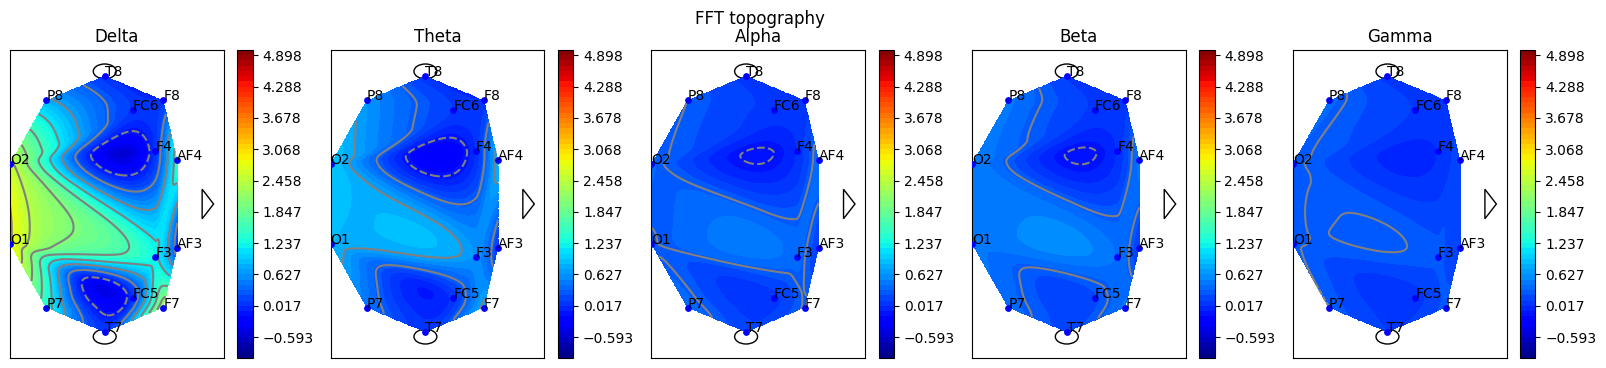

In [31]:

features = {
    # 'min': (-20, 15),
    # 'max': (-5, 20),
    # 'std': (-5, 7.5),
    # 'var': (-12.5, 75),
    'std': (-1, 5),
    # 'mean': (-.05, .02),
    # 'median': (-1, 1)
}
subjects = {
    1: [4],
    # 1: [3, 4, 5, 6, 7],
    # 2: [10, 11, 12, 13, 14],
    # 3: [17, 18, 19, 20, 21],
    # 4: [24, 25, 26, 27],
}
minute_start = 3
minute_end = 4
for sub_id, trials in subjects.items():
    for feature, (vmin, vmax) in features.items():
        # fig, axs = plt.subplots(3, 5, figsize=(20, 12))
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        # fig.suptitle(f'{feature} - subject {sub_id}')
        fig.suptitle(f'FFT topography')
        iax = 0
        # for i, label in enumerate(['focus', 'unfocus', ' drowsed']):
        for i, label in enumerate(['focus']):
            for j, (band_name, (band_low, band_high)) in enumerate(bands.items()):
                mean_data = None
                for trial in trials:
                    dat = get_trial_data(trial)
                    bpf_data = bp_filter(dat.to_numpy(), band_low, band_high, fs)
                    bpf_data = pd.DataFrame({c: bpf_data[:, ic] for ic, c in enumerate(dat.columns)})
                    if mean_data is None:
                        mean_data = mean_signal(bpf_data, (minute_start * 60) + i*600, (minute_end * 60) + i*600, 1, fs)
                    else:
                        mean_data += mean_signal(bpf_data, (minute_start * 60) + i*600, (minute_end * 60) + i*600, 1, fs)
                mean_data /= len(trials)
                # ax = axs[i][j]
                ax = axs[j]
                topography_map(mean_data, vmin=vmin, vmax=vmax, fig=fig, ax=ax, feature=feature)
                ax.set_title(band_name)
                ax.set_xticks([])
                ax.set_yticks([])
                # if j == 0:
                #     ax.set_ylabel(f'{label}')

In [32]:
mean_data.shape

(128, 14)

#### Spikes Topography Map

In [67]:
from functools import reduce

def spikes_in_trial_in_minute(trial, minute):
    trial_folder = Path(f'{EEG_FOLDER}/EEG_spikes/{trial}')
    label = 'drowsed'
    if minute < 10:
        label = 'focus'
    elif minute < 20:
        label = 'unfocus'
    minute_folder = trial_folder / label / str(minute)

    results = {
        band: {}
        for band in bands.keys()
    }
    main_clk_freq = 153600
    for band_name, (fmin, fmax) in bands.items():
        for ch in channels:
            count_resonators = 0
            for clk_freq in os.listdir(minute_folder / ch):
                clk_freq = int(clk_freq)
                ch_folder = minute_folder / ch
                # spikes_per_fs = np.zeros(60 * 128)
                spikes_per_fs = np.zeros(128)
                for resonator_output in os.listdir(ch_folder / str(clk_freq)):
                    resonator_freq = resonator_output[:-4]
                    if not (fmin <= float(resonator_freq) < fmax):
                        continue
                    events = np.load(ch_folder / str(clk_freq) / resonator_output)['spikes']
                    spikes_res = create_spikes_spectrogram(clk_freq, events, 1000/128, 60 * clk_freq)
                    spikes_res = spikes_res.reshape(-1, 128).sum(axis=0)
                    spikes_per_fs = spikes_res
                    # spikes_per_fs += abs(spikes_res - spikes_res.mean())
                    results[band_name][ch] = spikes_per_fs * main_clk_freq / clk_freq
                    count_resonators += 1

            results[band_name][ch] /= count_resonators

    return results

def split_and_aggregate(spikes_in_trial_minute, N):
    return {
        band: {
            ch: spikes.reshape(-1, N).sum(axis=1)
            for ch, spikes in d.items()
        }
        for band, d in spikes_in_trial_minute.items()
    }

def band_ch_add(d1, d2):
    res = {}
    for band, d in d1.items():
        res[band] = {}
        for ch in d.keys():
            res[band][ch] = d1[band][ch] + d2[band][ch]
    return res

def spikes_in_trial_in_minutes(trial, minutes, window_s=10):
    N = 60 // window_s
    spikes_minute = [
        split_and_aggregate(spikes_in_trial_in_minute(trial, minute), N)
        for minute in minutes
    ]
    return reduce(band_ch_add, spikes_minute)

### Topography by minutes

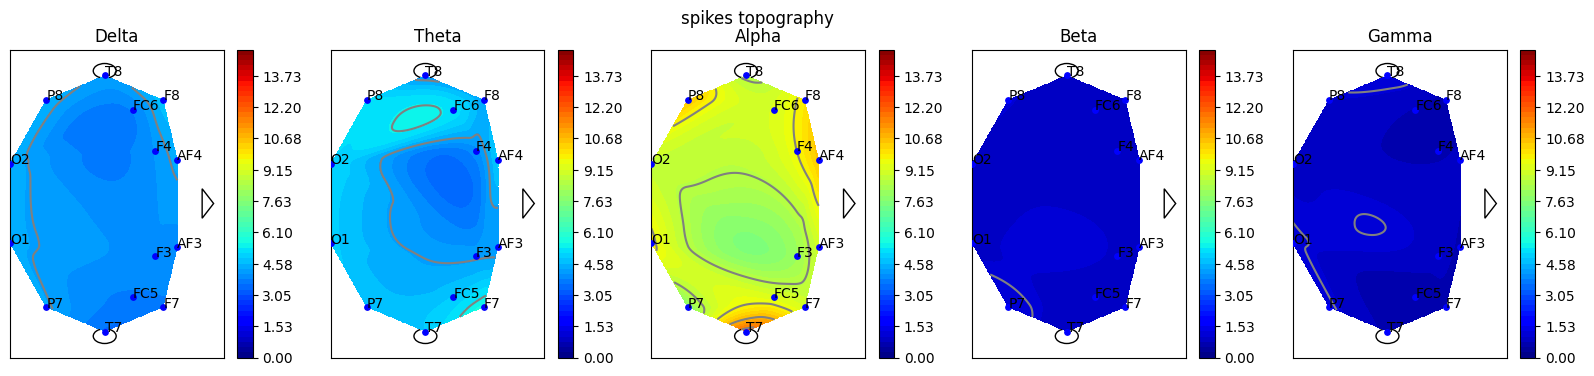

In [69]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle(f'spikes topography ')
label = 'focus'
minute = 4
i = 0

spikes = spikes_in_trial_in_minute(trial, minute)
for j, (band, data_dict) in enumerate(spikes.items()):
    df = pd.DataFrame(data_dict)
    df = df
    ax = axs[j]
    topography_map(df, vmin=0, vmax=15, fig=fig, ax=ax, feature='std')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_title(band)


(128, 14)

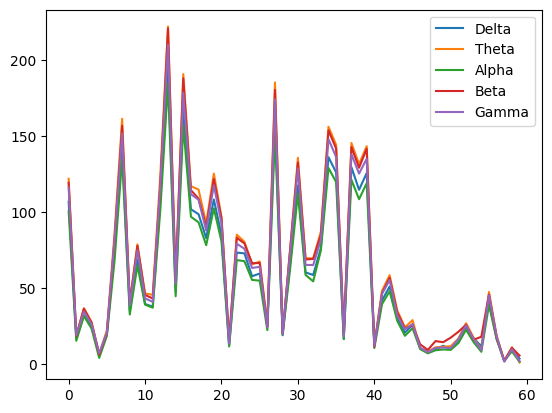

In [187]:
clk_freq_str = str(clk_freq)
ch = 'O2'
trial_folder = Path(f'{EEG_FOLDER}/EEG_spikes/{trial}')
minute_folder = trial_folder / label / str(minute)
ch_folder = minute_folder / ch
# spikes_per_10ms = np.zeros(6000)
# spikes_per_100ms = np.zeros(600)
spikes_per_1s = np.zeros(60)
for band_name, (fmin, fmax) in bands.items():
    count_resonators = 0
    spikes_per_1s = np.zeros(60)
    for resonator_output in os.listdir(ch_folder / clk_freq_str):
        resonator_freq = resonator_output[:-4]
        if not (fmin <= float(resonator_freq) < fmax):
            continue
        events = np.load(ch_folder / clk_freq_str / resonator_output)['spikes']
        spikes_res = create_spikes_spectrogram(int(clk_freq), events, 1000, 60 * clk_freq)
        spikes_per_1s += abs(spikes_res - spikes_res.mean())
        count_resonators += 1

    spikes_per_1s /= count_resonators
    plt.plot(spikes_per_1s, label=band_name)
plt.legend()

D:\Projects\Thesis\code\SNN-SCTN\utils\plotting_utils.py:85: UserWarning: No contour levels were found within the data range.
  ax.contour(xi, yi, zi, levels=levels, colors="grey", zorder=2)


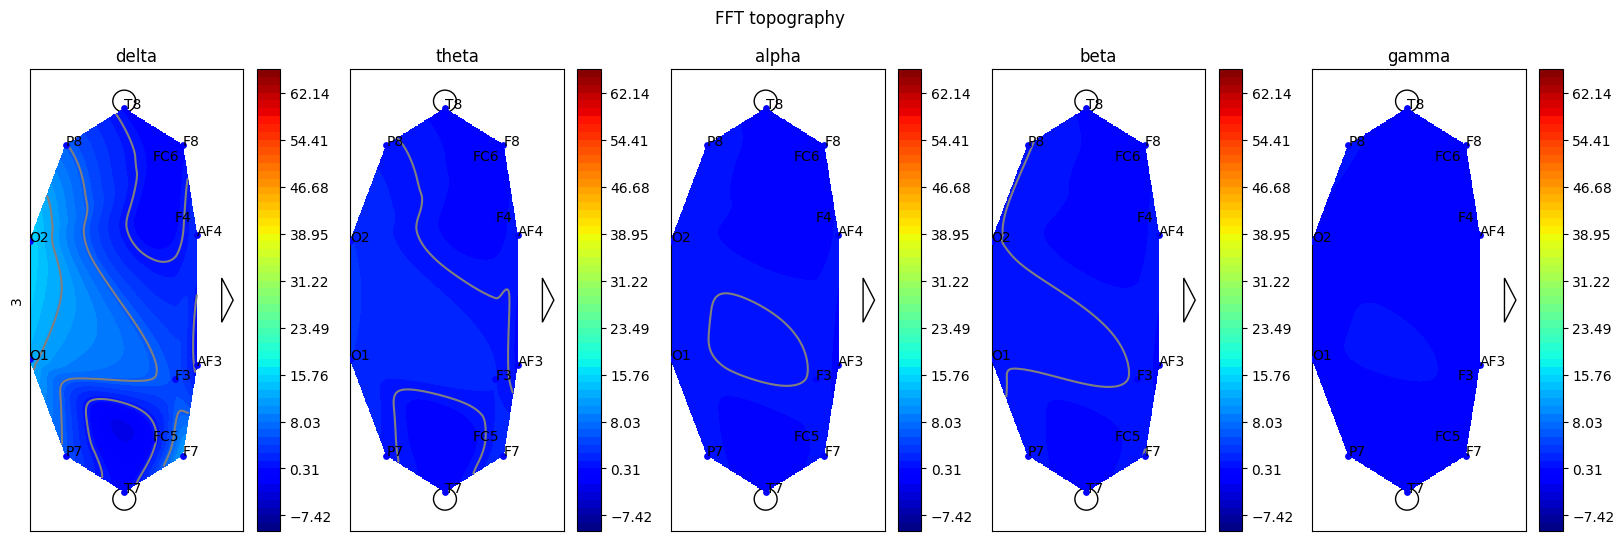

In [96]:

features = {
    # 'min': (-20, 15),
    # 'max': (-5, 20),
    # 'std': (-5, 7.5),
    'var': (-10, 66),
    # 'mean': (-.05, .02),
    # 'median': (-1, 1)
}
label = 'focus'
sub_id = 1
trial = 3
for feature, (vmin, vmax) in features.items():
    fig, axs = plt.subplots(1, 5, figsize=(20, 6))
    fig.suptitle(f'FFT topography')
    iax = 0
    for i, minute in enumerate([3]):
        for j, (band_name, (band_low, band_high)) in enumerate(bands.items()):
            dat = get_trial_data(trial)
            bpf_data = bp_filter(dat.to_numpy(), band_low, band_high, fs)
            bpf_data = pd.DataFrame({c: bpf_data[:, ic] for ic, c in enumerate(dat.columns)})
            x1 = minute * 60
            x2 = (minute + 1) * 60
            mean_data = mean_signal(bpf_data, x1, x2, 5, fs)
            # ax = axs[i][j]
            ax = axs[j]
            topography_map(mean_data, vmin=vmin, vmax=vmax, fig=fig, ax=ax, feature=feature)
            ax.set_title(band_name)
            ax.set_xticks([])
            ax.set_yticks([])

            if j == 0:
                ax.set_ylabel(minute)
            if i == 0:
                ax.set_title(band_name)

### Mean Topography

In [102]:
minutes

[3]

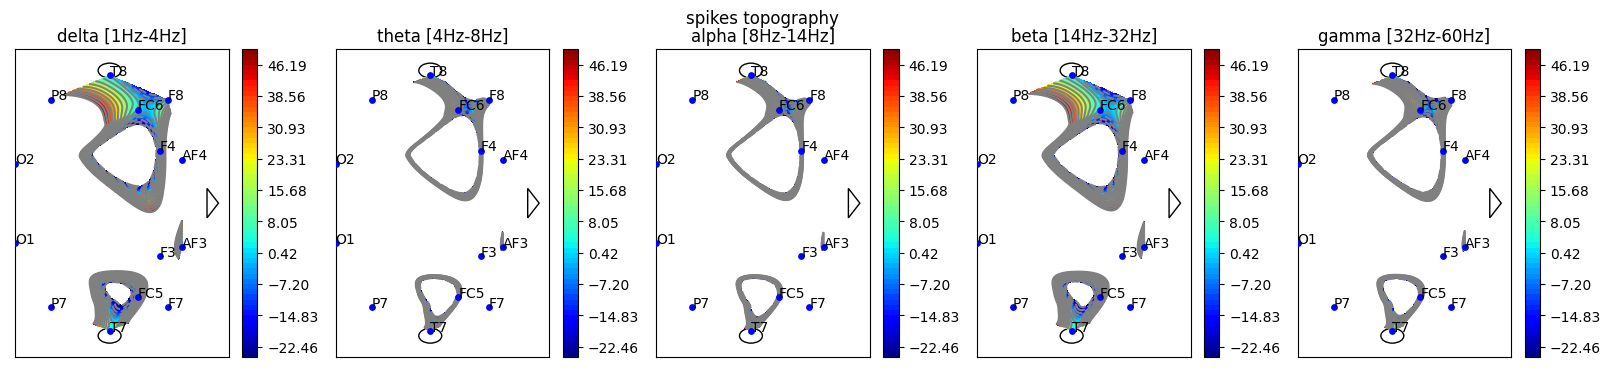

In [100]:
trial = 3
feature = 'std'
labels_minutes = {
    'focus': [3],
}
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle(f'spikes topography ')

for (label, minutes) in labels_minutes.items():
    spikes = spikes_in_trial_in_minutes(trial, minutes, window_s=1)
    for j, (band_name, data_dict) in enumerate(spikes.items()):
        df = pd.DataFrame(data_dict)
        df = df / 100
        ax = axs[j]
        topography_map(df, vmin=-25, vmax=50, fig=fig, ax=ax, feature='var')
        # topography_map(df, vmin=-2, vmax=7.5, fig=fig, ax=ax, feature='std')
        ax.set_xticks([])
        ax.set_yticks([])
        band_low = bands[band_name][0]
        band_high = bands[band_name][1]
        ax.set_title(f'{band_name} [{band_low}Hz-{band_high}Hz]')

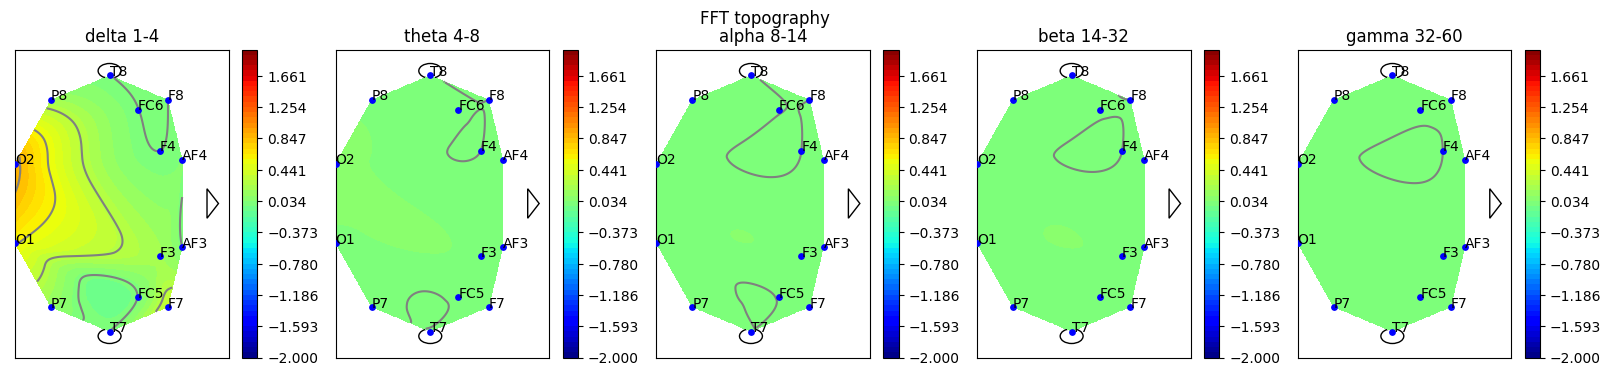

In [98]:
features = {
    # 'min': (-20, 15),
    # 'max': (-5, 20),
    # 'std': (-1, 3.5),
    'var': (-2, 2),
    # 'mean': (-.05, .02),
    # 'median': (-1, 1)
}
label = 'focus'
sub_id = 1
for feature, (vmin, vmax) in features.items():
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f'FFT topography')
    iax = 0
    for j, (band_name, (band_low, band_high)) in enumerate(bands.items()):
        dat = get_trial_data(trial)
        bpf_data = bp_filter(dat.to_numpy(), band_low, band_high, fs)
        bpf_data = pd.DataFrame({c: bpf_data[:, ic] for ic, c in enumerate(dat.columns)})
        x1 = 3 * 60
        x2 = 10 * 60
        mean_data = mean_signal(bpf_data, x1, x2, 1, fs)
        ax = axs[j]
        topography_map(mean_data, vmin=vmin, vmax=vmax, fig=fig, ax=ax, feature=feature)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{band_name} {band_low}-{band_high}')

# Test code cells

In [ ]:
features = {
    # 'min': (-20, 15),
    # 'max': (-5, 20),
    # 'std': (-1, 3.5),
    'var': (-2.5, 10),
    # 'mean': (-.05, .02),
    # 'median': (-1, 1)
}
label = 'focus'
sub_id = 1
trial = 3
for feature, (vmin, vmax) in features.items():
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f'FFT topography')
    iax = 0
    for j, (band_name, (band_low, band_high)) in enumerate(bands.items()):
        dat = get_trial_data(trial)
        bpf_data = bp_filter(dat.to_numpy(), band_low, band_high, fs)
        bpf_data = pd.DataFrame({c: bpf_data[:, ic] for ic, c in enumerate(dat.columns)})
        x1 = 3 * 60
        x2 = 10 * 60
        mean_data = mean_signal(bpf_data, x1, x2, 15, fs)
        ax = axs[j]
        topography_map(mean_data, vmin=vmin, vmax=vmax, fig=fig, ax=ax, feature=feature)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{band_name} {band_low}-{band_high}')

In [279]:
import numpy as np
import pywt

def bandpass_filter_dwt(signal, low_freq, high_freq, wavelet='db4', level=5):
    # Perform the DWT on the input signal
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Modify the approximation and detail coefficients to create the bandpass filter
    for i in range(1, level + 1):
        # Set coefficients outside the desired frequency range to zero
        if i != level:
            coeffs[i] *= 0
        else:
            # Set coefficients outside the desired frequency range to zero
            coeffs[i] = pywt.threshold(coeffs[i], low_freq, mode='greater')
            coeffs[i] = pywt.threshold(coeffs[i], high_freq, mode='less')

    # Reconstruct the filtered signal using inverse DWT
    filtered_signal = pywt.waverec(coeffs, wavelet)

    return filtered_signal

# Example usage
# Generate a sample signal
t = np.linspace(0, 1, 1000)
sin50 = np.sin(2 * np.pi * 50 * t)
signal = np.sin(2 * np.pi * 20 * t) + sin50 + np.sin(2 * np.pi * 100 * t)

coeffs = pywt.wavedec(signal, 'db4', level=4)
coeffs[1]

# # Apply bandpass filter using DWT
# filtered_signal = bandpass_filter_dwt(signal, low_freq=40, high_freq=60, wavelet='db4', level=2)
#
# # Plot the original signal and the filtered signal
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))
# plt.plot(t, signal, 'b', label='Original Signal')
# plt.plot(t, filtered_signal, 'r', label='Filtered Signal')
# plt.plot(t, sin50, 'g', label='f 50')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()

array([-0.02261579, -0.10146336, -0.28696421, -2.456823  , -1.35221597,
        3.80114251,  2.81224236, -2.63119889, -3.01093326, -0.02685711,
        2.1775922 ,  2.94948916, -0.96316785, -4.45808479, -0.47485626,
        3.87416106,  1.88440838, -1.65479859, -2.68349471, -1.31512391,
        2.68516197,  3.67623743, -1.90642385, -4.14074296,  0.17177189,
        2.73860685,  2.07531368, -0.50141119, -3.62070037, -1.68564162,
        3.6756913 ,  3.0600023 , -2.19370794, -3.03623232, -0.49753661,
        1.94479218,  3.27786551, -0.56474784, -4.52412466, -0.85510426,
        3.6091628 ,  2.13485377, -1.16981056, -2.73953081, -1.77397659,
        2.48221032,  3.93741692, -1.50523048, -4.13010633, -0.24379652,
        2.43721921,  2.36282053, -0.03714982, -3.6849444 , -2.08375246,
        3.43992923,  3.25960612, -1.73302785, -3.00449475, -0.95769205,
        1.67220004,  3.55694701, -0.14853995, -4.52500422, -0.4246248 ,
        0.46526752, -0.37875103,  2.03904003,  3.69947823])

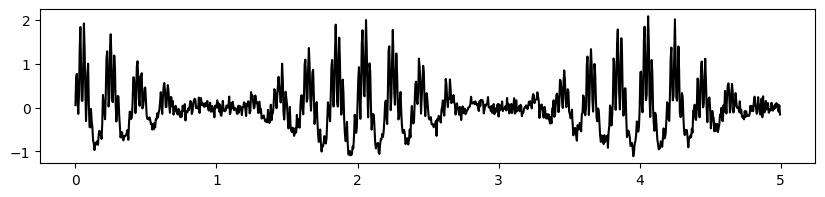

In [260]:
import emd
seconds = 60
sample_rate = 200
t = np.linspace(0, seconds, seconds*sample_rate)

# First we create a slow 4.25Hz oscillation with a 0.5Hz amplitude modulation
slow = np.sin(2*np.pi*5*t) * (.5+(np.cos(2*np.pi*.5*t)/2))

# Second, we create a faster 37Hz oscillation that is amplitude modulated by the first.
fast = .5*np.sin(2*np.pi*37*t) * (slow+(.5+(np.cos(2*np.pi*.5*t)/2)))

# We create our signal by summing the oscillation and adding some noise
x = slow+fast + np.random.randn(*t.shape)*.1

# Plot the first 5 seconds of data
plt.figure(figsize=(10, 2))
plt.plot(t[:sample_rate*5], x[:sample_rate*5], 'k')

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

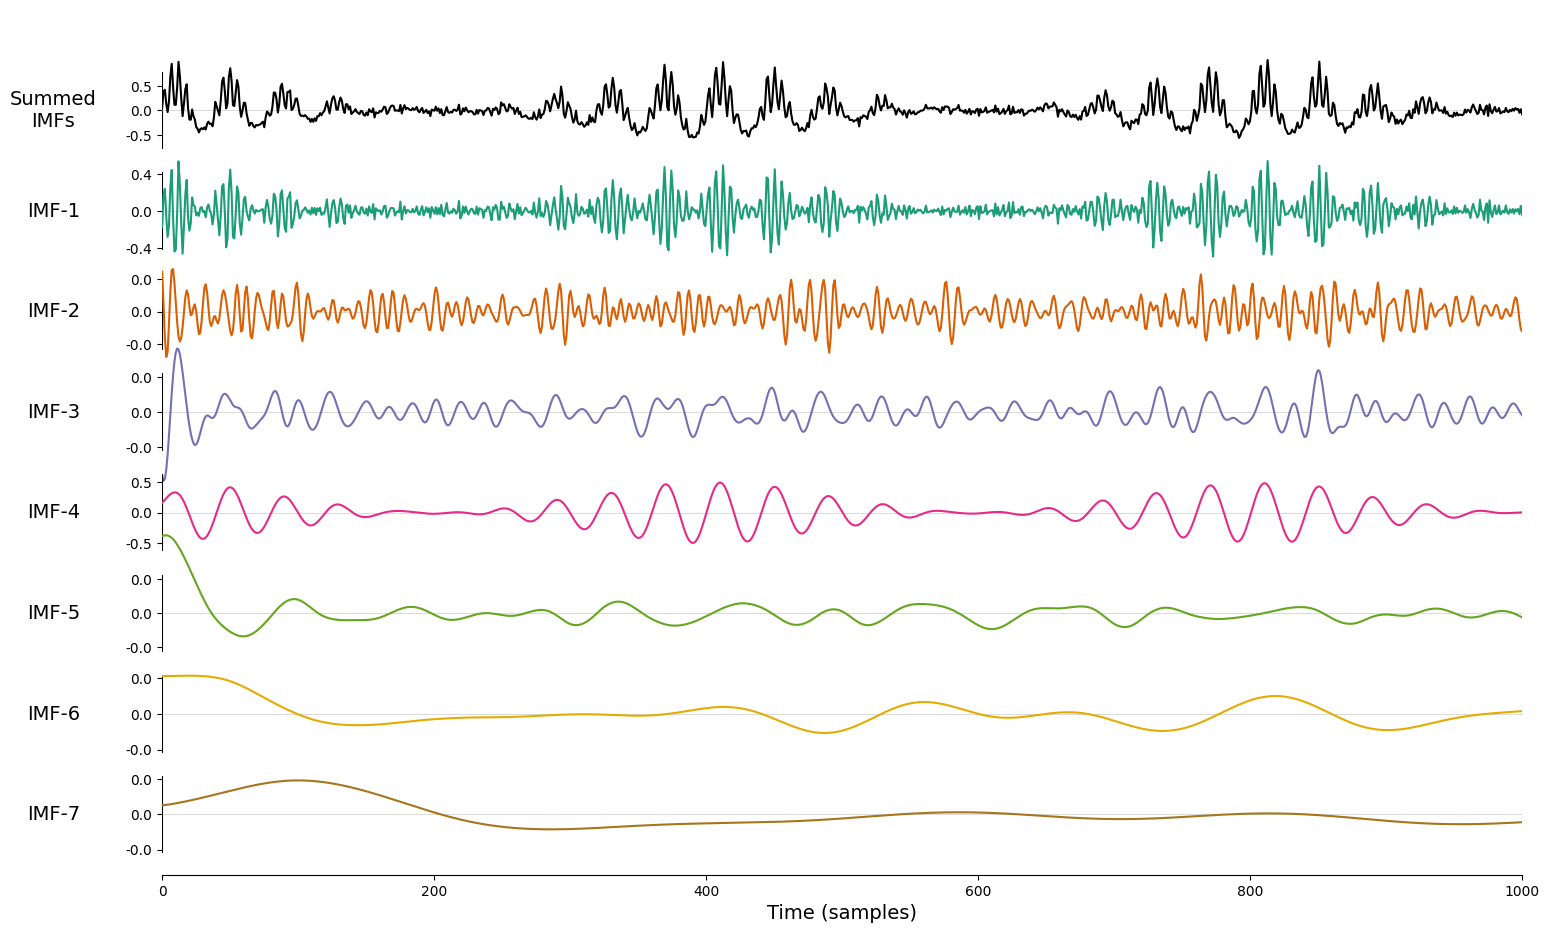

In [262]:
config = emd.sift.get_config('mask_sift')
config['max_imfs'] = 7
config['mask_freqs'] = 50/sample_rate
config['mask_amp_mode'] = 'ratio_sig'
config['imf_opts/sd_thresh'] = 0.05
imf = emd.sift.mask_sift(x, **config)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

# Visualise the IMFs
emd.plotting.plot_imfs(imf[:sample_rate*5, :], cmap=True, scale_y=True)